**Preparing the data **

In [ ]:
#upload a kaggle.json file before running this code. The json file can be obtained through your account settings in kaggle
!pip install -q kaggle
!apt-get install -y unzip
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/isic-2019
!unzip /content/isic-2019.zip

In [2]:
import numpy as np
import pandas as pd
!pip install torchsampler

groundtruth = '/content/ISIC_2019_Training_GroundTruth.csv'
groundtruthdf = pd.read_csv(groundtruth)

dxrow = pd.DataFrame([x for x in np.where(groundtruthdf == 1, groundtruthdf.columns,'').flatten().tolist() if len(x) > 0], columns= (["dx"]))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
metadata = '/content/ISIC_2019_Training_Metadata.csv'
metadatadf = pd.read_csv(metadata)

metadatadf.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [4]:
data = pd.concat([metadatadf, dxrow], axis=1, join='inner')
data.head()

,image,age_approx,anatom_site_general,lesion_id,sex,dx
0,ISIC_0000000,55.0,anterior torso,NaN,female,NV
1,ISIC_0000001,30.0,anterior torso,NaN,female,NV
2,ISIC_0000002,60.0,upper extremity,NaN,female,MEL
3,ISIC_0000003,30.0,upper extremity,NaN,male,NV
4,ISIC_0000004,80.0,posterior torso,NaN,male,MEL


In [5]:
groundtruthdf.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
class_dict = {'MEL': 'train/MEL/',
              'NV': 'train/NV/',
              'BCC': 'train/BCC/',
              'AK': 'train/AK/',
              'BKL': 'train/BKL/',
              'DF': 'train/DF/',  
              'VASC': 'train/VASC/',    
              'SCC': 'train/SCC/'}

import os
import shutil

image_dir = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input'

for index, row in data.iterrows():
    image_file = row['image']
    class_label = row['dx']
    dest_dir = class_dict[class_label]
    
    # Create the destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    # Copy the image file to the destination directory
    src_path = os.path.join(image_dir, image_file + '.jpg')
    dest_path = os.path.join(dest_dir, image_file + '.jpg')
    shutil.copy(src_path, dest_path)

# Define path to your train directory
train_path = 'train'

**Exploratory data analysis part**

<Axes: >

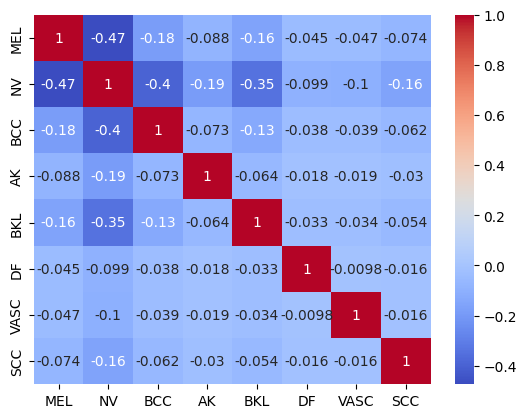

In [7]:
import seaborn as sns

# Create a new dataframe with only the class labels
class_df = groundtruthdf[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']]

# Create the correlation matrix
corr_matrix = class_df.corr()

# Plot the correlation matrix using seaborn
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

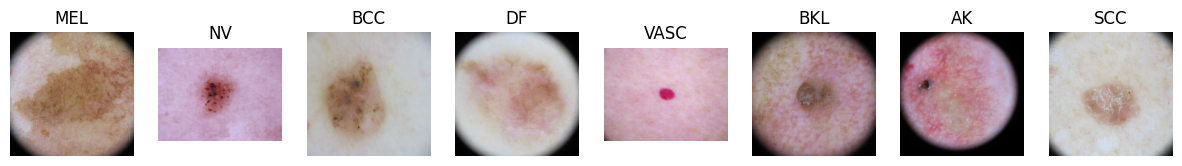

In [8]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to your image folder
image_folder = "/content/train"

# Get a list of all the classes in your image folder
class_names = os.listdir(image_folder)

# Create a figure with one row and as many columns as there are classes
fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5))

# Loop through each class and display an image
for i, class_name in enumerate(class_names):
    # Get the path to an example image in the current class
    class_folder = os.path.join(image_folder, class_name)
    image_files = os.listdir(class_folder)
    image_path = os.path.join(class_folder, image_files[0])

    # Load the image using Pillow
    image = Image.open(image_path)

    # Display the image in the appropriate subplot
    axs[i].imshow(image)
    axs[i].set_title(class_name)
    axs[i].axis("off")

# Show the plot
plt.show()

In [9]:
# Calculate summary statistics
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
 5   dx                   25331 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.2+ MB
None
         age_approx
count  24894.000000
mean      54.028481
std       18.130971
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max       85.000000


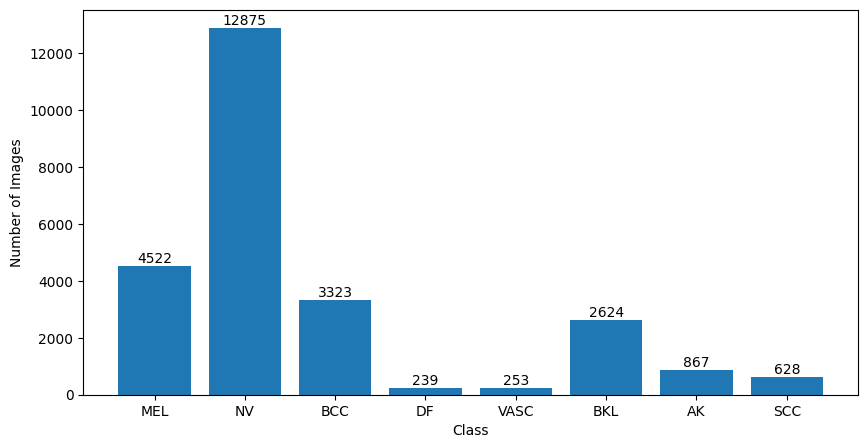

In [10]:
# Count the number of images in each class
class_counts = {}
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Plot the histogram of class frequencies with count of each class displayed on top
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(class_counts.keys(), class_counts.values())
ax.set_xlabel("Class")
ax.set_ylabel("Number of Images")

# Add counts as text on top of each bar
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), class_counts[list(class_counts.keys())[i]], 
            ha='center', va='bottom', fontsize=10)

plt.show()

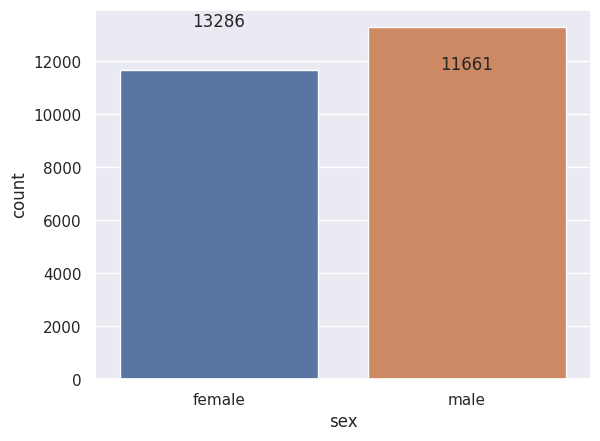

In [11]:
#this code shows the distribution between male and female
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
ax = sns.countplot(x="sex", data=data)

# Print class distribution
class_counts = data['sex'].value_counts()
for i, v in enumerate(class_counts):
    ax.text(i, v+10, str(v), ha='center', fontsize=12)

plt.show()

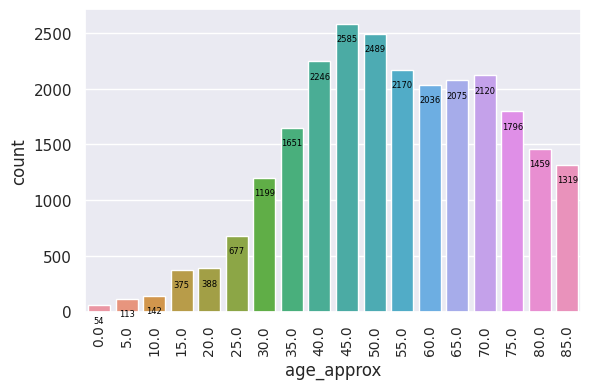

In [12]:
#this code shows the distribution of the patient ages. 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
ax = sns.countplot(x="age_approx", data=data)

# Adjust the space between the numbers on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)

# Display count for each age_approx group
for p in ax.patches:
    ax.annotate(f'\n{int(p.get_height())}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=6)

plt.show()

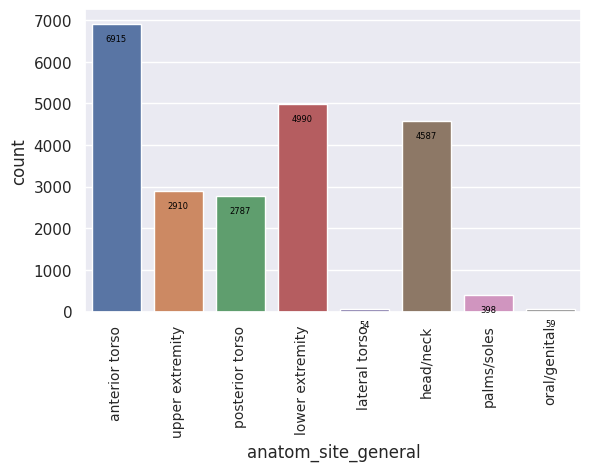

In [13]:
#this code shows the part of the body where the skin lesion is located
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
ax = sns.countplot(x="anatom_site_general", data=data)

# Adjust the space between the numbers on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)

# Display count for each age_approx group
for p in ax.patches:
    ax.annotate(f'\n{int(p.get_height())}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=6)

plt.show()

In [14]:
import torchvision
# Get a set of pretrained model weights
weights = torchvision.models.MaxVit_T_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# define the transform function that will be used in imagefolder to preprocess the data for MaxViT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

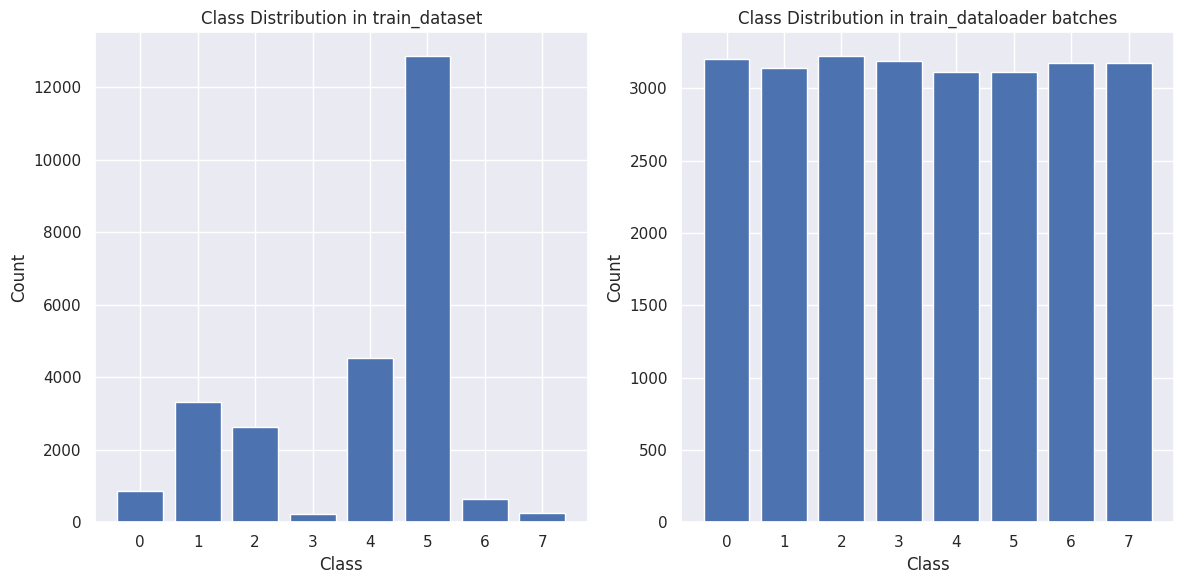

In [29]:
#This code was used to combat the class imbalance problem in the ISIC-2019 dataset in my thesis. The difference is visible in both charts
#where we can see that the samples are equally distributed in the right
import os
import shutil
import random
from torchvision import datasets, transforms
import torch.utils.data as data
from torchsampler import ImbalancedDatasetSampler
import matplotlib.pyplot as plt
from collections import Counter

# Get the labels for the samples in the training dataset
train_labels = train_dataset.targets

# Use the Counter class from the collections module to count the number of samples in each class
class_counts = Counter(train_labels)

# Check the class distribution of the batches in train_dataloader
batch_class_counts = Counter()
for batch in train_dataloader:
    batch_labels = batch[1]
    batch_class_counts.update(batch_labels.tolist())

# Convert dictionaries to lists for plotting
class_labels = list(class_counts.keys())
class_values = list(class_counts.values())
batch_labels = list(batch_class_counts.keys())
batch_values = list(batch_class_counts.values())

# Create a figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the class distribution in train_dataset
ax1.bar(class_labels, class_values)
ax1.set_title('Class Distribution in train_dataset')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')

# Plot the class distribution after applying random up/down sampling
ax2.bar(batch_labels, batch_values)
ax2.set_title('Class Distribution after applying random up/down sampling')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()